In [1]:
import pymc as pm
import numpy as np
import arviz as az
import scipy.stats as sps
import matplotlib.pyplot as plt

# Suppress PyTensor warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='pytensor')

# Set plot style
az.style.use('arviz-darkgrid')

In [2]:
a = sps.bernoulli(p = 0.1)
conversions = a.rvs(100)
conversions

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [3]:
np.mean(conversions)

np.float64(0.1)

In [4]:
print(conversions.size)
print(np.sum(conversions))

100
10


In [5]:
# Store values as Python native types to avoid PyTensor type issues
n_trials = 100
n_successes = 13

with pm.Model() as model:
    # Use explicit float type for Beta parameters
    prior_conversion = pm.Beta("prior_conversion", alpha=2.0, beta=10.0)
    # Use the stored integer values
    liklihood = pm.Binomial("liklihood", n=n_trials, p=prior_conversion, observed=n_successes)
    # Sample with explicit return type
    idata = pm.sample(1000, return_inferencedata=True, progressbar=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [prior_conversion]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [6]:
# Summary statistics of the posterior
az.summary(idata, var_names=["prior_conversion"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prior_conversion,0.134,0.033,0.076,0.196,0.001,0.0,1618.0,2599.0,1.0


/tmp/ipykernel_3590306/656114128.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


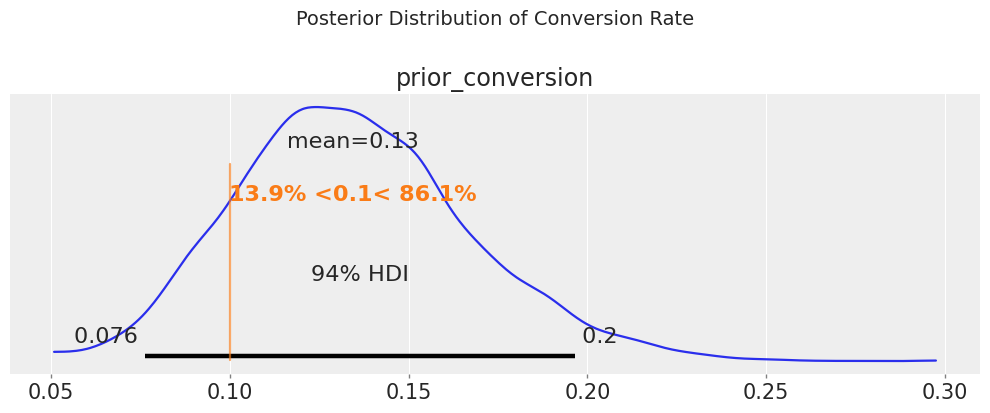

In [7]:
# Plot posterior distribution
az.plot_posterior(idata, var_names=["prior_conversion"], 
                  ref_val=0.1,  # True conversion rate used to generate data
                  figsize=(10, 4))
plt.suptitle("Posterior Distribution of Conversion Rate", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

/tmp/ipykernel_3590306/455749345.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


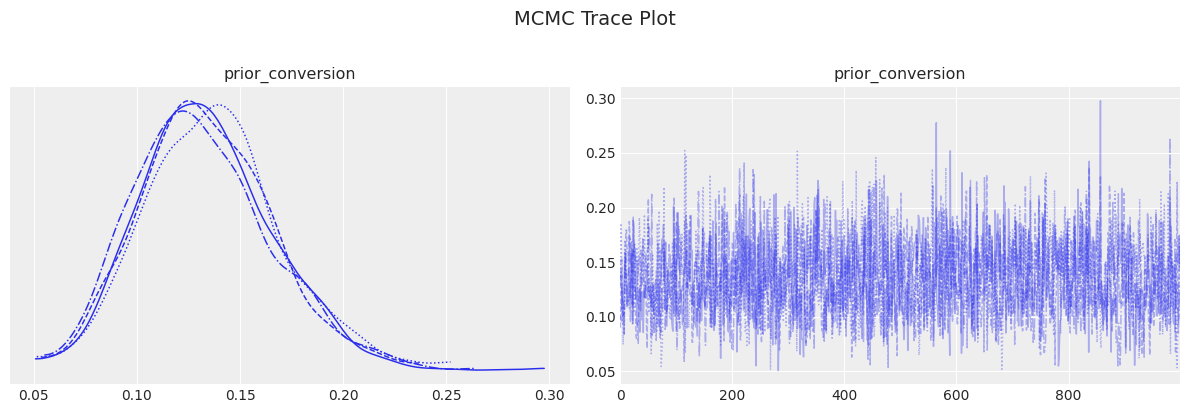

In [8]:
# Trace plot to check MCMC convergence
az.plot_trace(idata, var_names=["prior_conversion"], figsize=(12, 4))
plt.suptitle("MCMC Trace Plot", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

/tmp/ipykernel_3590306/1095802768.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


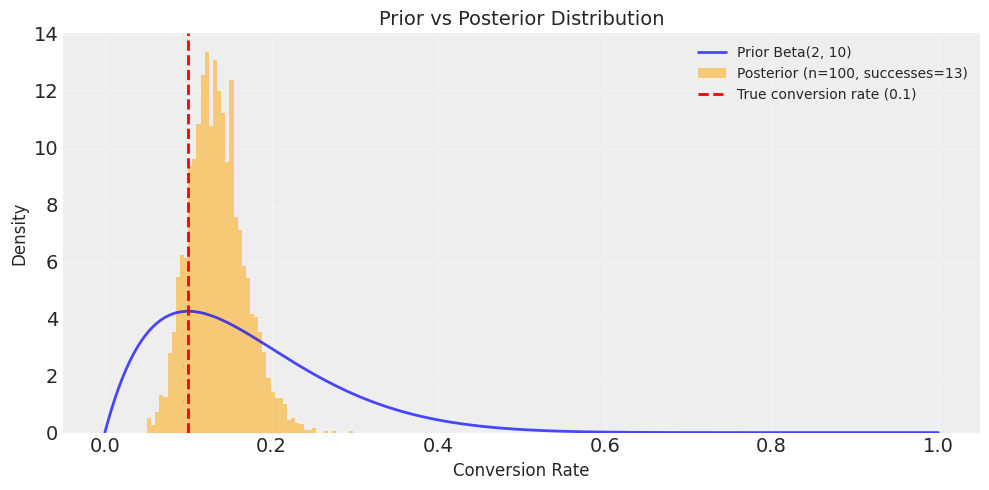

In [9]:
# Compare prior and posterior distributions
fig, ax = plt.subplots(figsize=(10, 5))

# Plot prior
x = np.linspace(0, 1, 1000)
prior_dist = sps.beta(2, 10)
ax.plot(x, prior_dist.pdf(x), label='Prior Beta(2, 10)', color='blue', linewidth=2, alpha=0.7)

# Plot posterior (extract samples)
posterior_samples = idata.posterior['prior_conversion'].values.flatten()
ax.hist(posterior_samples, bins=50, density=True, alpha=0.5, 
        label=f'Posterior (n={n_trials}, successes={n_successes})', color='orange')

# Add reference line for true value
ax.axvline(0.1, color='red', linestyle='--', linewidth=2, label='True conversion rate (0.1)')

ax.set_xlabel('Conversion Rate', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Prior vs Posterior Distribution', fontsize=14)
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

/tmp/ipykernel_3590306/3640594407.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


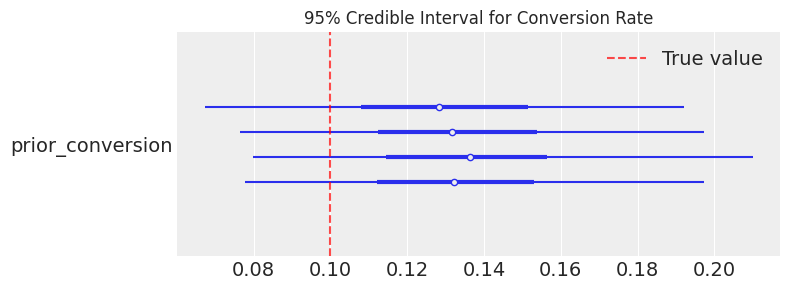

In [10]:
# Forest plot showing credible intervals
az.plot_forest(idata, var_names=["prior_conversion"], 
               hdi_prob=0.95, figsize=(8, 3))
plt.axvline(0.1, color='red', linestyle='--', alpha=0.7, label='True value')
plt.title('95% Credible Interval for Conversion Rate', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# Posterior statistics
print("=" * 60)
print("POSTERIOR INFERENCE SUMMARY")
print("=" * 60)
print(f"\nData: {n_successes} conversions out of {n_trials} trials")
print(f"Observed conversion rate: {n_successes/n_trials:.3f}")
print(f"\nPrior: Beta(2, 10) with mean = {2/(2+10):.3f}")

# Posterior statistics
post_mean = posterior_samples.mean()
post_std = posterior_samples.std()
post_hdi = az.hdi(idata, var_names=["prior_conversion"], hdi_prob=0.95)

print(f"\nPosterior Mean: {post_mean:.3f}")
print(f"Posterior Std: {post_std:.3f}")
print(f"95% HDI: [{post_hdi['prior_conversion'].values[0]:.3f}, {post_hdi['prior_conversion'].values[1]:.3f}]")

# Probability that conversion rate is above certain thresholds
prob_above_10 = (posterior_samples > 0.10).mean()
prob_above_15 = (posterior_samples > 0.15).mean()
print(f"\nP(conversion rate > 0.10) = {prob_above_10:.3f}")
print(f"P(conversion rate > 0.15) = {prob_above_15:.3f}")
print("=" * 60)

POSTERIOR INFERENCE SUMMARY

Data: 13 conversions out of 100 trials
Observed conversion rate: 0.130

Prior: Beta(2, 10) with mean = 0.167

Posterior Mean: 0.134
Posterior Std: 0.033
95% HDI: [0.073, 0.200]

P(conversion rate > 0.10) = 0.861
P(conversion rate > 0.15) = 0.299
